In [1]:
# We load the competition data

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)
from sklearn.feature_selection import (
    mutual_info_regression
)
from sklearn.model_selection import (
    train_test_split
)

# Predict Podcast Listening Time

### Playground Series - Season 5, Episode 4

### Your Goal: 

Your task it to predict listening time of a podcast episode.

### Root Mean Squared Error (RMSE)

Submissions are scored on the root mean squared error.

### Submission File

For each id in the test set, you must predict the Listening_Time_minutes of the podcast. The file should contain a header and have the following format:

id,Listening_Time_minutes

750000,45.437
750001,45.437
750002,45.437
etc.

### Timeline

Start Date - April 1, 2025
Entry Deadline - Same as the Final Submission Deadline
Team Merger Deadline - Same as the Final Submission Deadline
Final Submission Deadline - April 30, 2025
All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

In [3]:
# We load the data

listening_train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv", index_col="id")

In [4]:
listening_train.shape

(750000, 11)

In [5]:
listening_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [6]:
listening_train.describe(exclude = np.number)

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,750000,750000,750000,750000,750000,750000
unique,48,100,10,7,4,3
top,Tech Talks,Episode 71,Sports,Sunday,Night,Neutral
freq,22847,10515,87606,115946,196849,251291


In [7]:
listening_train.describe().style.background_gradient(cmap='Greens')

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,64.504738,59.859901,52.236449,1.348855,45.437406
std,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.730000,39.410000,28.380000,0.000000,23.178350
50%,63.840000,60.050000,53.580000,1.000000,43.379460
75%,94.070000,79.530000,76.600000,2.000000,64.811580
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [8]:
listening_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 68.7+ MB


# EDA

In [9]:
# Function to view the data of each variable in detail

def detail_columns(data, colum):

    print(
        "Variable: ", colum,
        "\nFormat: ", data[colum].dtype,
        "\nNumber of null values: ", data[colum].isnull().sum(),
        "\nUnique values: ", data[colum].nunique(),
        "\nDistribution of values: \n", data[colum].value_counts()
    )

In [10]:
# Establishing the seaborn aesthetic

sns.set_style("dark")

## Listening Time minutes(Target)

In [11]:
detail_columns(listening_train, "Listening_Time_minutes")

Variable:  Listening_Time_minutes 
Format:  float64 
Number of null values:  0 
Unique values:  42807 
Distribution of values: 
 Listening_Time_minutes
0.00000     8551
5.82000      124
10.55000     108
8.75000      108
19.71000      98
            ... 
90.89242       3
58.15856       3
50.74736       2
21.75737       2
69.18963       2
Name: count, Length: 42807, dtype: int64


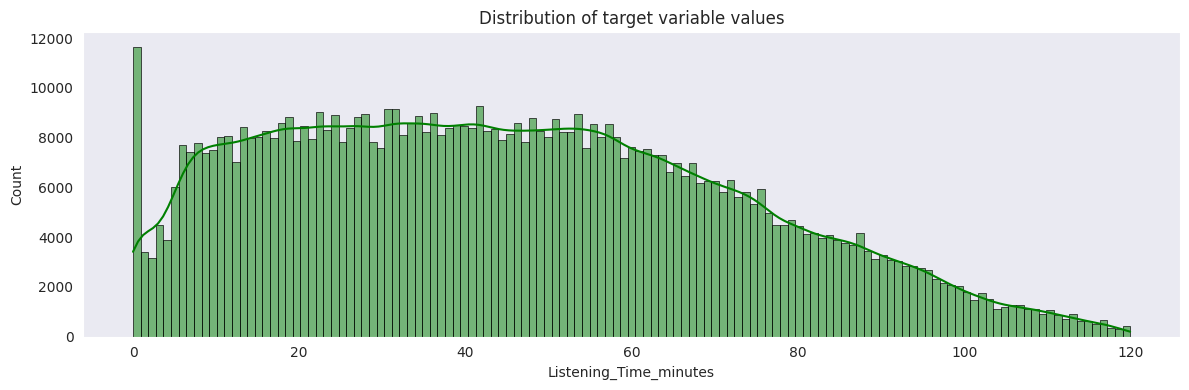

In [12]:
# We analyze the distribution of the data

fig, axes = plt.subplots(figsize=(12, 4))

sns.histplot(
    data=listening_train, 
    x="Listening_Time_minutes", 
    color="green",
    edgecolor="k",
    kde=True
)

plt.title(label="Distribution of target variable values")
plt.tight_layout()
plt.show()

We are faced with a variable with high cardinality, and we see that there is a positive asymmetry. Most values are in the range of 10 to 60 minutes, the value 0 being the one that groups the largest amount. We did not observe any null or erroneous values.

## Podcast Name & Episode Title

In [13]:
detail_columns(listening_train, "Podcast_Name")
print("-" * 50)
detail_columns(listening_train, "Episode_Title")

Variable:  Podcast_Name 
Format:  object 
Number of null values:  0 
Unique values:  48 
Distribution of values: 
 Podcast_Name
Tech Talks             22847
Sports Weekly          20053
Funny Folks            19635
Tech Trends            19549
Fitness First          19488
Business Insights      19480
Style Guide            19364
Game Day               19272
Melody Mix             18889
Criminal Minds         17735
Finance Focus          17628
Detective Diaries      17452
Crime Chronicles       17374
Athlete's Arena        17327
Fashion Forward        17280
Tune Time              17254
Business Briefs        17012
Lifestyle Lounge       16661
True Crime Stories     16373
Sports Central         16191
Digital Digest         16171
Humor Hub              16144
Mystery Matters        16002
Comedy Corner          15927
Joke Junction          15074
Wellness Wave          15009
Sport Spot             14778
Gadget Geek            14770
Home & Living          14686
Laugh Line             14673
Li

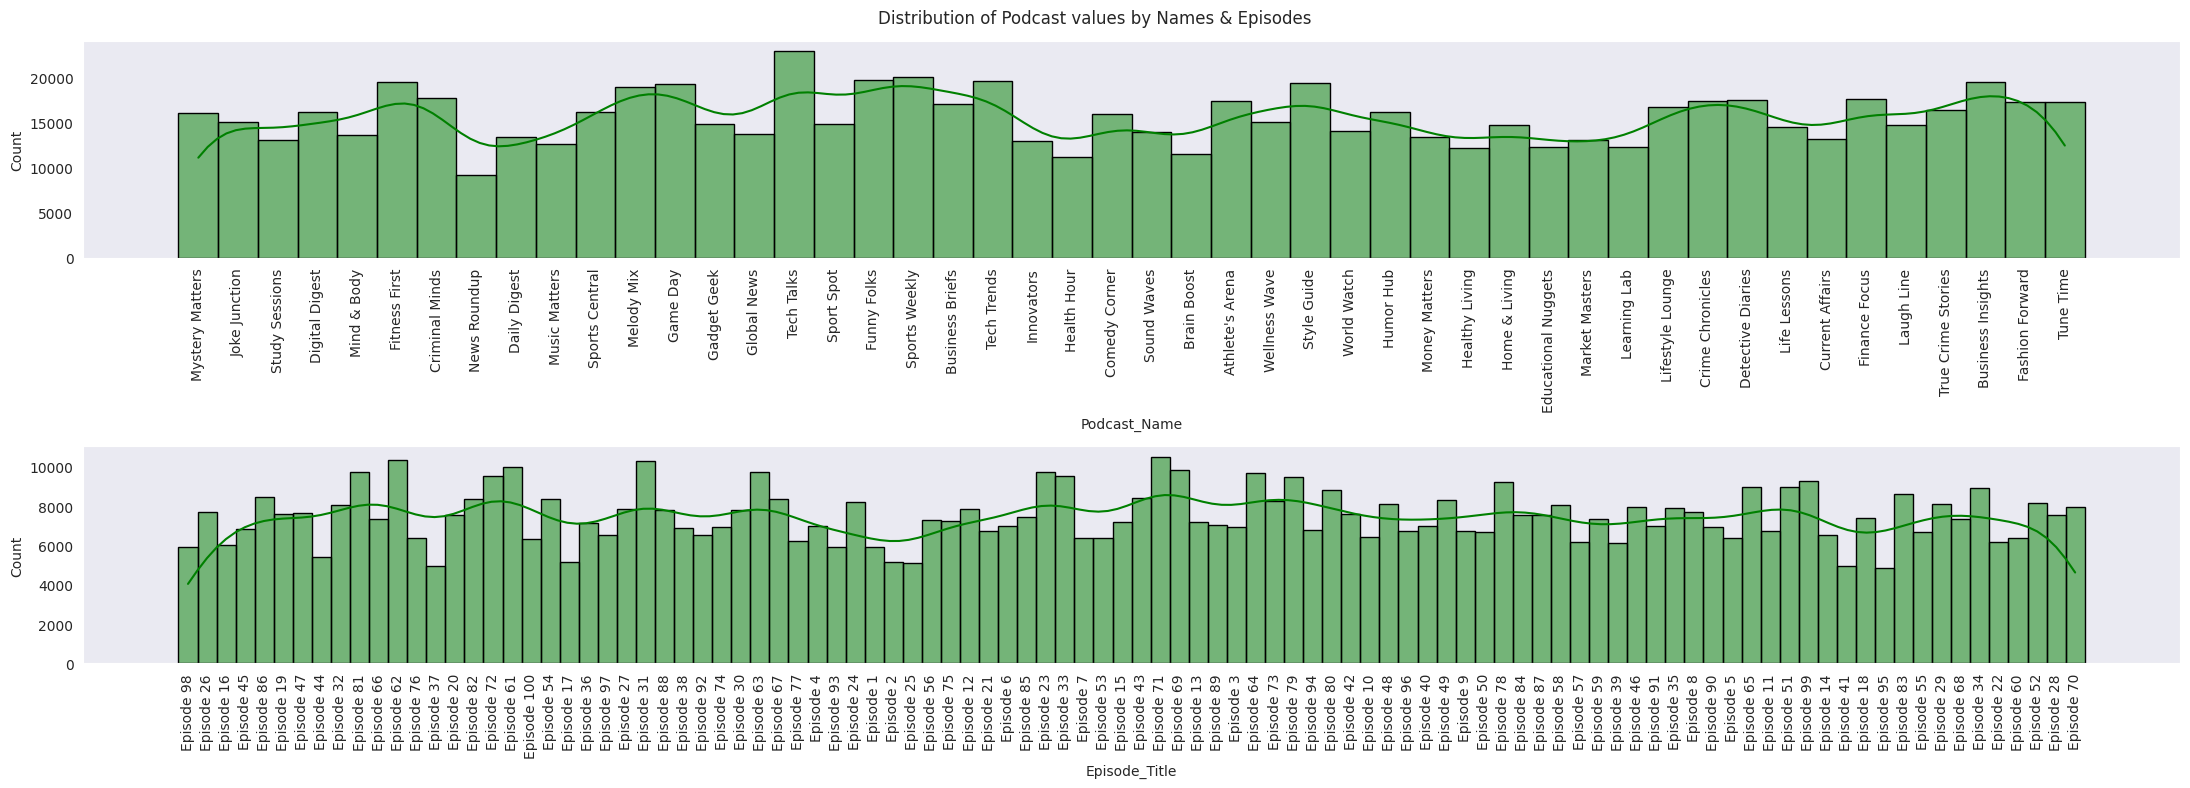

In [14]:
# We analyze the distribution of the data

fig, axes = plt.subplots(nrows=2, figsize=(22, 8))

sns.histplot(
    data=listening_train, 
    x="Podcast_Name", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
).tick_params(axis='x', labelrotation=90)

sns.histplot(
    data=listening_train, 
    x="Episode_Title",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
).tick_params(axis='x', labelrotation=90)

plt.suptitle(t="Distribution of Podcast values by Names & Episodes")
plt.tight_layout()
plt.show()

We found variables with a high number of labels, representing the 48 podcasts in the dataset, and also the number of episodes. Based on the number of unique values, we can deduce that the podcasts with the highest number of episodes have 100. The podcast with the highest number of samples is about tech talks. Both variables do not present null data or observed errors.

## Episode Length & Sentiment

In [15]:
detail_columns(listening_train, "Episode_Length_minutes")
print("-" * 50)
detail_columns(listening_train, "Episode_Sentiment")

Variable:  Episode_Length_minutes 
Format:  float64 
Number of null values:  87093 
Unique values:  12268 
Distribution of values: 
 Episode_Length_minutes
6.600000     925
34.400000    617
30.690000    576
31.680000    533
31.460000    491
            ... 
14.498053      1
8.115479       1
93.660301      1
98.298620      1
62.167294      1
Name: count, Length: 12268, dtype: int64
--------------------------------------------------
Variable:  Episode_Sentiment 
Format:  object 
Number of null values:  0 
Unique values:  3 
Distribution of values: 
 Episode_Sentiment
Neutral     251291
Negative    250116
Positive    248593
Name: count, dtype: int64


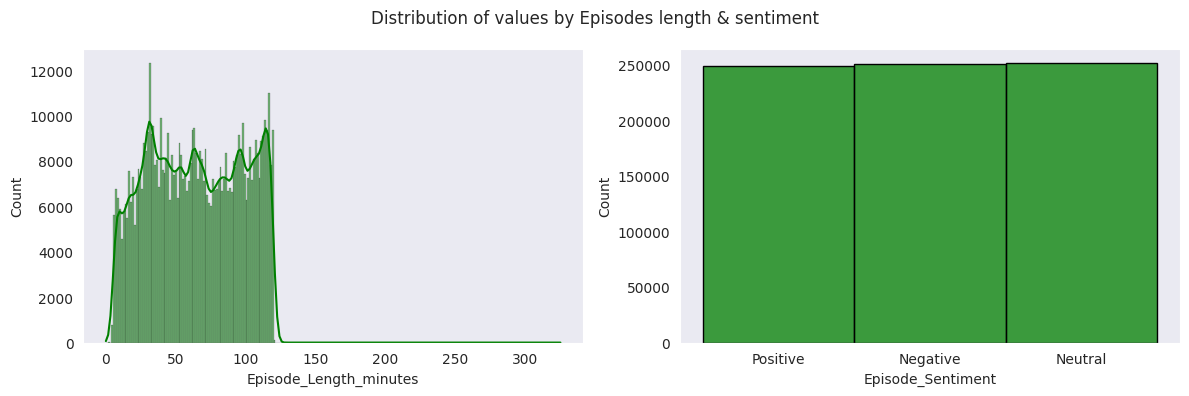

In [16]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=listening_train, 
    x="Episode_Length_minutes", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=listening_train, 
    x="Episode_Sentiment",
    color="green",
    edgecolor="k",
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Episodes length & sentiment")
plt.tight_layout()
plt.show()

We observed a large amount of null data for episode length, as well as a distribution of values centered on a range of 20 to 120 minutes with positive skewness. Regarding sentiment about the episodes, we saw an even distribution across labels, and no null data were found. We observed no erroneous data for either variable.

## Genre & Number of Ads

In [17]:
detail_columns(listening_train, "Genre")
print("-" * 50)
detail_columns(listening_train, "Number_of_Ads")

Variable:  Genre 
Format:  object 
Number of null values:  0 
Unique values:  10 
Distribution of values: 
 Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64
--------------------------------------------------
Variable:  Number_of_Ads 
Format:  float64 
Number of null values:  1 
Unique values:  12 
Distribution of values: 
 Number_of_Ads
0.00      217592
1.00      214069
3.00      160173
2.00      158156
103.25         2
53.37          1
103.91         1
103.00         1
53.42          1
103.75         1
12.00          1
103.88         1
Name: count, dtype: int64


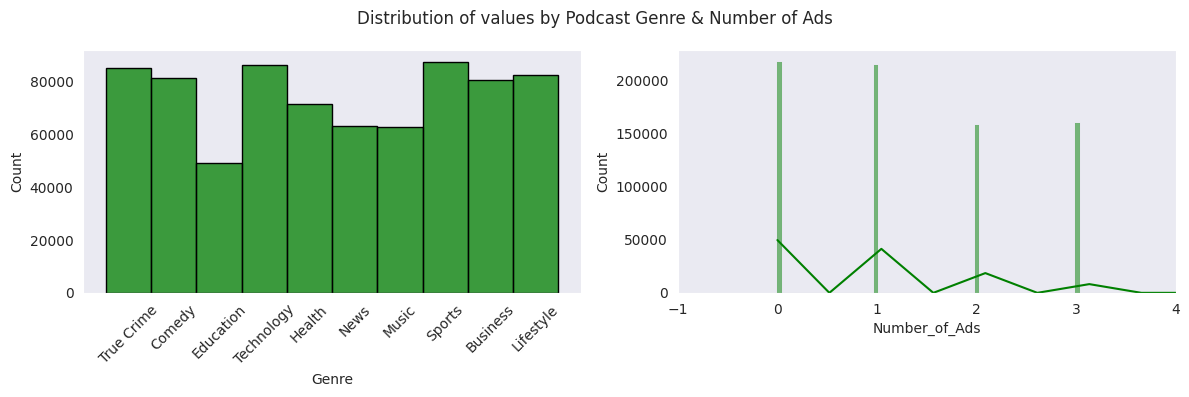

In [18]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=listening_train, 
    x="Genre", 
    color="green",
    edgecolor="k",
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)

sns.histplot(
    data=listening_train, 
    x="Number_of_Ads",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Podcast Genre & Number of Ads")
plt.xlim(-1, 4)
plt.tight_layout()
plt.show()

We found 10 different podcast genres in the dataset, with a reasonably even distribution across the different labels. Regarding the number of ads, we found four clear values, representing either no ads or between one and three present in the podcast. We can also observe that there are eight unique values grouping nine samples that represent outliers or could be considered erroneous or incorrectly entered data, which we will analyze more specifically. Regarding the null data, we can observe a single missing value, that we could fill with the mode grouped by Podcast.

In [19]:
# We obtain the rows that we are interested in analyzing

null_ads = listening_train.loc[listening_train["Number_of_Ads"] > 3]

null_ads

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
211159,Wellness Wave,Episode 83,64.83,Health,48.46,Sunday,Evening,NaN,53.37,Positive,50.44892
283606,Health Hour,Episode 15,109.93,Health,67.81,Sunday,Morning,77.90,103.91,Neutral,103.89696
436577,Sports Central,Episode 64,115.25,Sports,28.58,Saturday,Afternoon,23.65,103.00,Neutral,103.12686
495919,Comedy Corner,Episode 79,64.83,Comedy,48.37,Saturday,Evening,NaN,53.42,Neutral,50.44892
537705,Sound Waves,Episode 64,112.27,Music,28.95,Saturday,Morning,10.15,103.75,Neutral,103.12686
567235,Detective Diaries,Episode 21,16.13,True Crime,49.11,Tuesday,Evening,43.17,12.00,Positive,6.49000
602553,Sound Waves,Episode 53,112.27,Music,28.19,Tuesday,Morning,23.15,103.25,Neutral,103.12686
672139,Sound Waves,Episode 35,115.74,Music,28.95,Tuesday,Afternoon,23.50,103.25,Neutral,103.12686
683147,Crime Chronicles,Episode 15,109.93,True Crime,59.66,Tuesday,Evening,77.91,103.88,Neutral,103.89696


We found no errors in these samples other than the advertising record. We also didn't observe any logical parameters that would allow us to think any reason for these values being correct. They could be replaced by the Podcast trend for advertising.

## Host & Guest Popularity percentage

In [20]:
detail_columns(listening_train, "Host_Popularity_percentage")
print("-" * 50)
detail_columns(listening_train, "Guest_Popularity_percentage")

Variable:  Host_Popularity_percentage 
Format:  float64 
Number of null values:  0 
Unique values:  8038 
Distribution of values: 
 Host_Popularity_percentage
38.68000     560
26.72000     523
56.29000     490
30.14000     445
31.57000     439
            ... 
86.71356       1
118.69000      1
87.99900       1
107.02000      1
86.64906       1
Name: count, Length: 8038, dtype: int64
--------------------------------------------------
Variable:  Guest_Popularity_percentage 
Format:  float64 
Number of null values:  146030 
Unique values:  10019 
Distribution of values: 
 Guest_Popularity_percentage
68.530     378
29.700     339
42.690     332
54.590     300
41.290     298
          ... 
90.485       1
32.044       1
110.140      1
107.080      1
105.440      1
Name: count, Length: 10019, dtype: int64


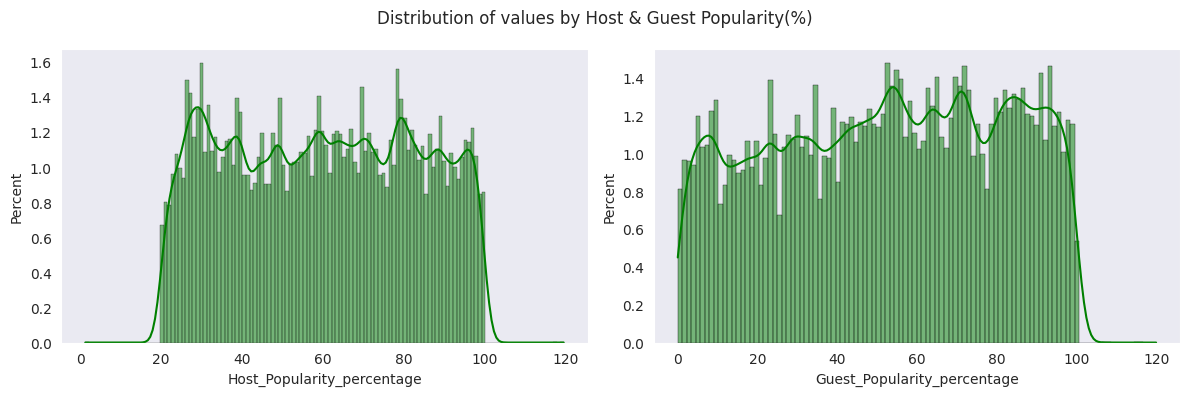

In [21]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=listening_train, 
    x="Host_Popularity_percentage", 
    color="green",
    edgecolor="k",
    kde=True,
    stat="percent",
    ax=axes[0]
)

sns.histplot(
    data=listening_train, 
    x="Guest_Popularity_percentage",
    color="green",
    edgecolor="k",
    kde=True,
    stat="percent",
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Host & Guest Popularity(%)")
plt.tight_layout()
plt.show()

We observed that we did not find any null data for host popularity, but we did find some outliers and erroneous values that needed to be addressed. The values were distributed between 20 and 100 percent. Regarding guest popularity, we found a high percentage of missing values, and some potential outliers and erroneous values, with the distribution ranging from 0 to 100 percent.

In [22]:
# We obtain the rows that we are interested in analyzing

null_popularity = listening_train.loc[
    (listening_train["Host_Popularity_percentage"] > 100) | 
    (listening_train["Guest_Popularity_percentage"] > 100)
]

print(f"Total samples with a percentage greater than 100: {len(null_popularity)} \n")

Total samples with a percentage greater than 100: 44 



Considering these values as incorrect, we could round them up to 100. We could also apply this to the other values in both columns, or take one or two decimal places. For null values, we could group by podcast and apply the mode or average popularity percentage to fill in the values.

## Publication Day & Time

In [23]:
detail_columns(listening_train, "Publication_Day")
print("-" * 50)
detail_columns(listening_train, "Publication_Time")

Variable:  Publication_Day 
Format:  object 
Number of null values:  0 
Unique values:  7 
Distribution of values: 
 Publication_Day
Sunday       115946
Monday       111963
Friday       108237
Wednesday    107886
Thursday     104360
Saturday     103505
Tuesday       98103
Name: count, dtype: int64
--------------------------------------------------
Variable:  Publication_Time 
Format:  object 
Number of null values:  0 
Unique values:  4 
Distribution of values: 
 Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
Name: count, dtype: int64


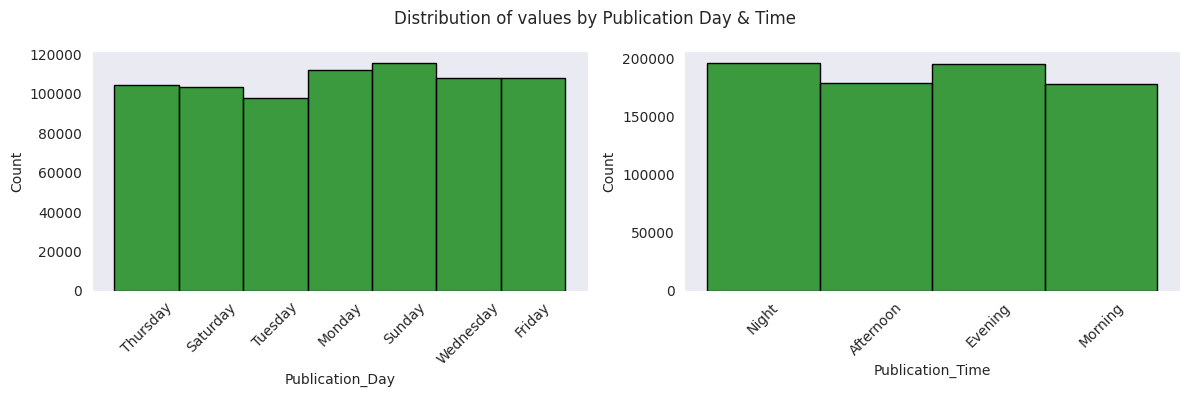

In [24]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=listening_train, 
    x="Publication_Day", 
    color="green",
    edgecolor="k",
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)

sns.histplot(
    data=listening_train, 
    x="Publication_Time",
    color="green",
    edgecolor="k",
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Distribution of values by Publication Day & Time")
plt.tight_layout()
plt.show()

We found no erroneous or null data in either variable. The data are reasonably evenly distributed across all labels. We logically found that Sunday nights are the most popular time for podcast consumption. We could combine and transform these two variables into a "Date" variable, by day of the week and time range.

# Data wrangling

We will proceed to complete or correct the missing and erroneous values that we have found from our exploratory analysis of the data.

In [25]:
# We make a copy of the original dataset

listening_new = listening_train.copy()

In [26]:
# We check that no duplicate data is found

print(f"Length: {len(listening_new.duplicated())}")
print(f"Duplicates: {listening_new.duplicated().sum()}")

Length: 750000
Duplicates: 0


In [27]:
# We check for null values

null_values = (
    pd.DataFrame(
        {f"Amount of Null Data": listening_new.isnull().sum(), 
         "Percentage of Null Data" : (
             listening_new.isnull().sum()) / (len(listening_new)) * (100)
        }))

null_values.style.background_gradient(cmap="Greens")

,Amount of Null Data,Percentage of Null Data
Podcast_Name,0,0.000000
Episode_Title,0,0.000000
Episode_Length_minutes,87093,11.612400
Genre,0,0.000000
Host_Popularity_percentage,0,0.000000
Publication_Day,0,0.000000
Publication_Time,0,0.000000
Guest_Popularity_percentage,146030,19.470667
Number_of_Ads,1,0.000133
Episode_Sentiment,0,0.000000


We found null data to handle in three variables. We'll take a first approach to complete them based on our analysis, and then we can evaluate the result and determine if another approach is required.

## Episode_Length_minutes

In [28]:
# We fill null values with the mean groupby Podcast

listening_new["Episode_Length_minutes"] = (
    listening_new["Episode_Length_minutes"].fillna(
        listening_new.groupby("Podcast_Name")["Episode_Length_minutes"].transform("mean")
    )
)

print(
    "Number of null values: ", listening_new["Episode_Length_minutes"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Episode_Length_minutes"].value_counts(normalize=True)
)

Number of null values:  0 

 Distribution of values: 
 Episode_Length_minutes
64.307741    0.003676
67.117406    0.003409
63.733542    0.003273
62.711968    0.003211
62.850526    0.003109
               ...   
44.000846    0.000001
8.438445     0.000001
86.442500    0.000001
77.137000    0.000001
62.167294    0.000001
Name: proportion, Length: 12316, dtype: float64


## Number_of_Ads

In [29]:
# We replace the erroneous values with the mode of the Podcasts

listening_new["Number_of_Ads"] = (
    listening_new["Number_of_Ads"].apply(lambda x: np.NaN if x>3 else x)
)

listening_new["Number_of_Ads"] = (
    listening_new["Number_of_Ads"].fillna(
        listening_new.groupby("Podcast_Name")["Number_of_Ads"].transform(lambda v: v.mode()[0])
    )
)

print(
    "Number of null values: ", listening_new["Number_of_Ads"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Number_of_Ads"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Number_of_Ads
0.0    217597
1.0    214074
3.0    160173
2.0    158156
Name: count, dtype: int64


## Host_Popularity_percentage

In [30]:
# We replace the erroneous values

listening_new["Host_Popularity_percentage"] = np.where(
    listening_new["Host_Popularity_percentage"] > 100, 100, listening_new["Host_Popularity_percentage"]
).round(decimals=2)

print(
    "Number of Unique values: ", listening_new["Host_Popularity_percentage"].nunique(), "\n",
    "Distribution of values: \n", listening_new["Host_Popularity_percentage"].value_counts(normalize=True)
)

Number of Unique values:  8007 
 Distribution of values: 
 Host_Popularity_percentage
38.68    0.000747
26.72    0.000697
56.29    0.000653
30.14    0.000593
31.57    0.000585
           ...   
1.77     0.000003
1.30     0.000001
39.18    0.000001
1.73     0.000001
1.47     0.000001
Name: proportion, Length: 8007, dtype: float64


## Guest_Popularity_percentage

In [31]:
# We replace the erroneous values

listening_new["Guest_Popularity_percentage"] = np.where(
    listening_new["Guest_Popularity_percentage"] > 100, 100, listening_new["Guest_Popularity_percentage"]
)

# We fill null values with the mean groupby Podcast

listening_new["Guest_Popularity_percentage"] = (
    listening_new["Guest_Popularity_percentage"].fillna(
        listening_new.groupby("Podcast_Name")["Guest_Popularity_percentage"].transform("mean")
    )
).round(decimals=2)

print(
    "Number of Unique values: ", listening_new["Guest_Popularity_percentage"].nunique(), "\n",
    "Number of null values: ", listening_new["Guest_Popularity_percentage"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Guest_Popularity_percentage"].value_counts(normalize=True)
)

Number of Unique values:  9991 
 Number of null values:  0 

 Distribution of values: 
 Guest_Popularity_percentage
52.24    0.009640
51.27    0.008721
51.88    0.006383
52.60    0.006055
52.63    0.005424
           ...   
42.36    0.000001
59.65    0.000001
3.88     0.000001
49.24    0.000001
11.60    0.000001
Name: proportion, Length: 9991, dtype: float64


We initially applied averaging by podcast to fill in the missing data for the variable. After evaluating the initial results, we will test other tools to fill in the nearly 20% missing data for 'Guest_Popularity_percentage'.

In [32]:
# We changed the format for more efficient memory usage

listening_new[listening_new.select_dtypes(["object"]).columns] = (
    listening_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

In [33]:
listening_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 750000 non-null  category
 1   Episode_Title                750000 non-null  category
 2   Episode_Length_minutes       750000 non-null  float64 
 3   Genre                        750000 non-null  category
 4   Host_Popularity_percentage   750000 non-null  float64 
 5   Publication_Day              750000 non-null  category
 6   Publication_Time             750000 non-null  category
 7   Guest_Popularity_percentage  750000 non-null  float64 
 8   Number_of_Ads                750000 non-null  float64 
 9   Episode_Sentiment            750000 non-null  category
 10  Listening_Time_minutes       750000 non-null  float64 
dtypes: category(6), float64(5)
memory usage: 38.6 MB


# Hypotheses & Questions of interest

Below we will develop some questions to analyze the data in greater depth and try to establish the most important characteristics to predict the listening time of the podcasts.

In [34]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

- Which podcasts are the most popular and which are the least popular?
- What is the average listening time for each of them?

In [35]:
popularity_ltm = listening_new.pivot(
    columns="Podcast_Name", values="Listening_Time_minutes"
)

In [36]:
popularity = popularity_ltm.sum().sort_values(ascending=False)

print(popularity)

Podcast_Name
Tech Talks             1.054600e+06
Sports Weekly          9.418091e+05
Melody Mix             9.086658e+05
Fitness First          8.891128e+05
Funny Folks            8.853424e+05
Style Guide            8.728061e+05
Tech Trends            8.710068e+05
Business Insights      8.612759e+05
Game Day               8.500873e+05
Crime Chronicles       8.283740e+05
Detective Diaries      8.159689e+05
Tune Time              8.091802e+05
Athlete's Arena        8.080410e+05
Business Briefs        8.016242e+05
Fashion Forward        7.856085e+05
Criminal Minds         7.723315e+05
Finance Focus          7.621128e+05
Lifestyle Lounge       7.589392e+05
True Crime Stories     7.574390e+05
Humor Hub              7.398241e+05
Mystery Matters        7.363858e+05
Digital Digest         7.239633e+05
Comedy Corner          6.996781e+05
Gadget Geek            6.945997e+05
Wellness Wave          6.892778e+05
Home & Living          6.813658e+05
Sports Central         6.767894e+05
Sport Spot     

In [37]:
print(
    " Most listened Podcast: {0:0.3f}\n".format(max(popularity)),
    "Least listened Podcast: {0:0.3f}\n".format(min(popularity))
)

 Most listened Podcast: 1054599.795
 Least listened Podcast: 391585.024



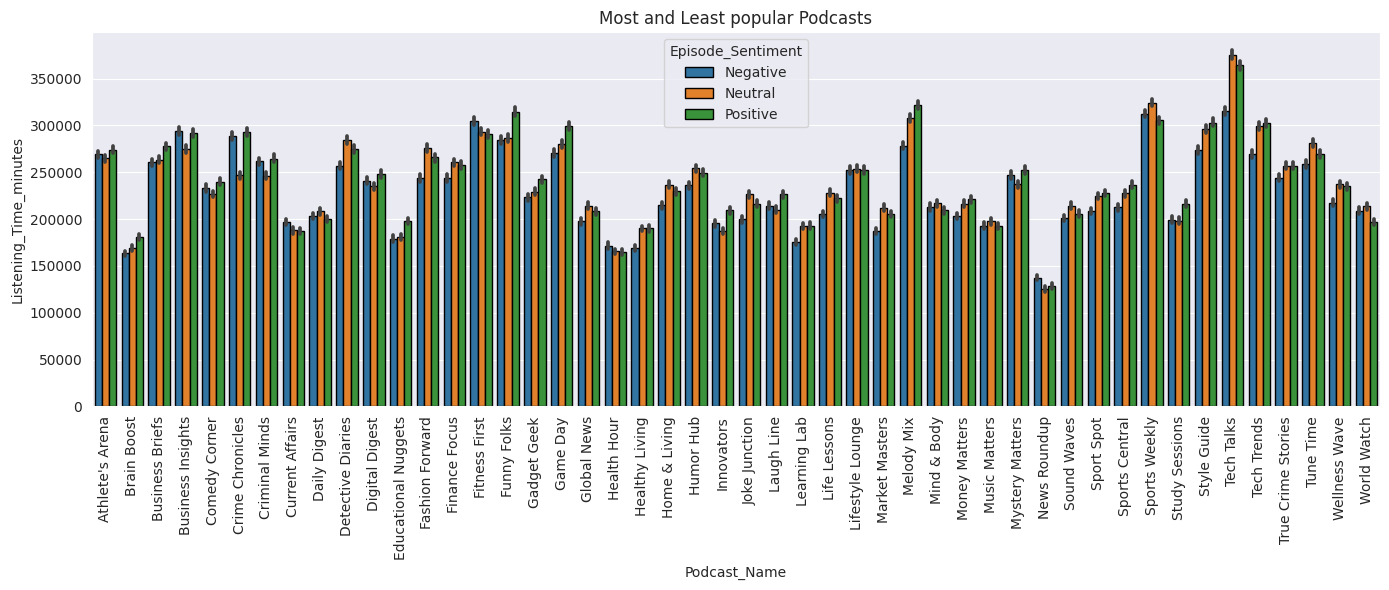

In [38]:
# We analyze the popularity

fig, axes = plt.subplots(figsize=(14, 6))

sns.barplot(
    data=listening_new, 
    x="Podcast_Name",
    y="Listening_Time_minutes",
    estimator="sum",
    hue="Episode_Sentiment",
    edgecolor="k"
).tick_params(axis='x', labelrotation=90)

plt.title(label="Most and Least popular Podcasts")
plt.tight_layout()
plt.show()

In [39]:
popularity_ltm.describe()

Podcast_Name,Athlete's Arena,Brain Boost,Business Briefs,Business Insights,Comedy Corner,Crime Chronicles,Criminal Minds,Current Affairs,Daily Digest,Detective Diaries,...,Sports Central,Sports Weekly,Study Sessions,Style Guide,Tech Talks,Tech Trends,True Crime Stories,Tune Time,Wellness Wave,World Watch
count,17327.000000,11543.000000,17012.000000,19480.000000,15927.000000,17374.000000,17735.000000,13138.000000,13391.000000,17452.000000,...,16191.000000,20053.000000,13053.000000,19364.000000,22847.000000,19549.000000,16373.000000,17254.000000,15009.000000,14043.000000
mean,46.634791,44.409651,47.121103,44.213344,43.930314,47.678948,43.548438,43.534962,45.697657,46.755035,...,41.800348,46.965997,47.047780,45.073646,46.159224,44.555055,46.261466,46.898123,45.924299,44.103977
std,26.598116,26.511354,26.504574,26.439289,26.877233,28.636860,26.975589,27.045850,26.591550,26.865088,...,26.181978,25.524092,28.762171,26.639277,28.091935,27.884268,27.036863,27.087551,27.114679,26.872162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.300510,22.920760,24.714850,22.819080,21.339295,23.515228,21.446525,21.945098,23.705510,24.777315,...,20.994815,26.990310,23.273190,23.482193,23.440000,21.190000,24.434090,25.888168,24.270420,21.999580
50%,46.440490,42.684130,45.570450,41.968150,41.465750,45.452570,41.234480,40.169595,43.797740,45.039610,...,39.945060,45.712230,44.309240,42.654250,43.379460,40.551070,44.781220,43.644580,44.660590,42.488140
75%,65.967065,62.512565,67.424958,62.603650,62.609995,70.271545,62.033715,63.346275,64.975875,66.248025,...,60.564635,64.687720,67.832690,64.560973,65.601860,65.719560,65.592220,66.051132,65.394820,63.438185
max,119.740000,119.740000,119.660000,119.440000,119.800000,119.900000,119.800000,119.800000,119.970000,119.970000,...,119.970000,119.800000,119.900000,119.970000,119.900000,119.740000,119.790000,119.970000,119.800000,119.560000


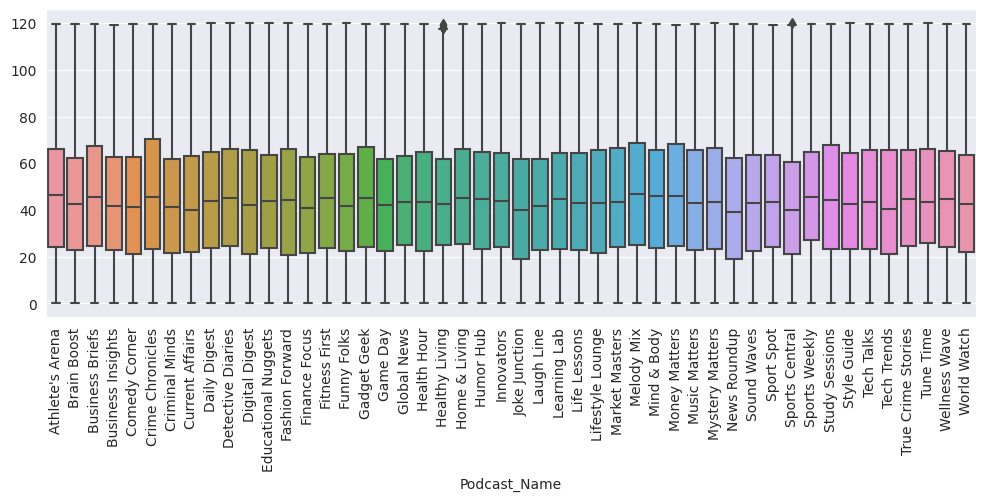

In [40]:
# We analyze the popularity

fig, axes = plt.subplots(figsize=(12, 4))

sns.boxplot(data=popularity_ltm).tick_params(axis='x', labelrotation=90)

We didn't observe major differences; all podcasts fall within the same average listening time range. Considering that Tech Talks has the largest number of samples and therefore the longest listening time, and News Roundup the smallest, we could consider them among the most and least popular. In addition, the sentiment about the podcast shows more positive and more negative respectively. However, considering factors such as the number of episodes each podcast has and their length, we can't reach a clear conclusion.

- What is the most popular genre, and how much does it influence listening time?
- How much does the popularity of the host or guests influence the listening time?

In [41]:
genre_ltm = listening_new.pivot(
    columns="Genre", values="Listening_Time_minutes"
)

genre_ltm.describe()

Genre,Business,Comedy,Education,Health,Lifestyle,Music,News,Sports,Technology,True Crime
count,80521.000000,81453.000000,49100.000000,71416.000000,82461.000000,62743.000000,63385.000000,87606.000000,86256.000000,85059.000000
mean,45.538151,44.426441,45.736640,45.741413,45.523117,46.578394,44.406144,44.935722,45.634749,46.042507
std,27.016292,26.935076,27.432706,27.124952,27.172606,27.475405,26.808621,26.117835,27.904583,27.426368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.531360,22.113070,23.389950,23.866575,22.815210,24.210000,22.468140,23.797760,22.599310,23.437215
50%,43.303140,41.945080,43.942355,44.510890,43.533900,44.220000,42.003820,43.467305,42.899730,44.060490
75%,65.194770,63.300850,64.525880,64.526910,65.378980,66.280000,63.447530,63.483290,65.723760,66.397650
max,119.660000,119.970000,119.970000,119.900000,119.970000,119.970000,119.970000,119.970000,119.970000,119.970000


In [42]:
popularity_genre = genre_ltm.sum().sort_values(ascending=False)

print(popularity_genre)

Genre
Sports        3.936639e+06
Technology    3.936271e+06
True Crime    3.916330e+06
Lifestyle     3.753882e+06
Business      3.666777e+06
Comedy        3.618667e+06
Health        3.266669e+06
Music         2.922468e+06
News          2.814683e+06
Education     2.245669e+06
dtype: float64


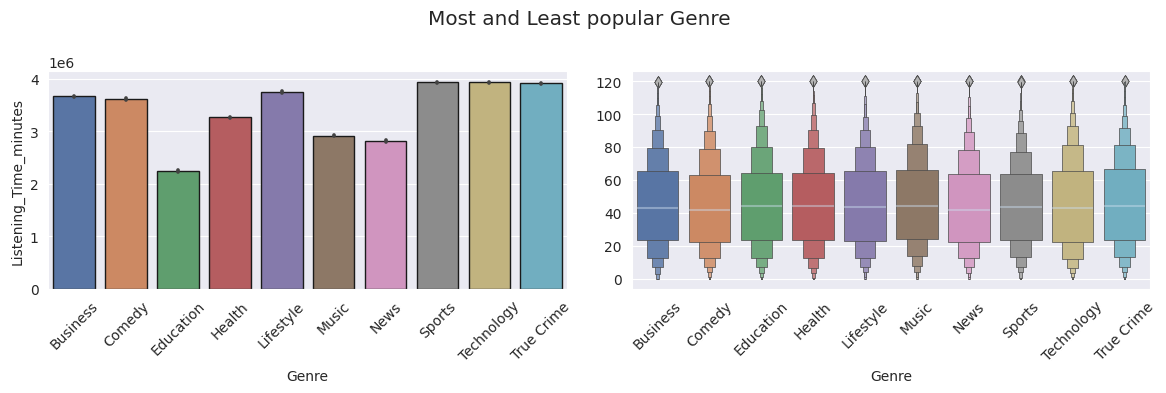

In [43]:
# We analyze the Genre popularity

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
sns.set_theme()

sns.barplot(
    data=listening_new, 
    x="Genre",
    y="Listening_Time_minutes",
    estimator="sum",
    edgecolor="k",
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)

sns.boxenplot(
    data=genre_ltm,
    linewidth=.5,
    line_kws=dict(linewidth=1.5, color="#cde"),
    flier_kws=dict(facecolor=".7", linewidth=.5),
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Most and Least popular Genre")
plt.tight_layout()
plt.show()

We didn't find any major differences in average listening time, but when grouping the podcasts by genre, we logically see that there are. Some genres, such as technology, crime, and sports, recorded the longest listening time, while educational podcasts were the least listened to.

In [44]:
df_host_guest = listening_new[[
    "Host_Popularity_percentage", 
    "Guest_Popularity_percentage"
]]

df_guest_old_stat = listening_train[["Guest_Popularity_percentage"]].rename(
    columns={"Guest_Popularity_percentage" : "Guest_old_stats"}
)

df_host_guest_stats = pd.concat([df_host_guest, df_guest_old_stat], axis=1)

df_host_guest_stats.describe()

,Host_Popularity_percentage,Guest_Popularity_percentage,Guest_old_stats
count,750000.000000,750000.000000,603970.000000
mean,59.859482,52.233200,52.236449
std,22.872221,25.533619,28.451241
min,1.300000,0.000000,0.000000
25%,39.410000,34.550000,28.380000
50%,60.050000,52.430000,53.580000
75%,79.530000,71.040000,76.600000
max,100.000000,100.000000,119.910000


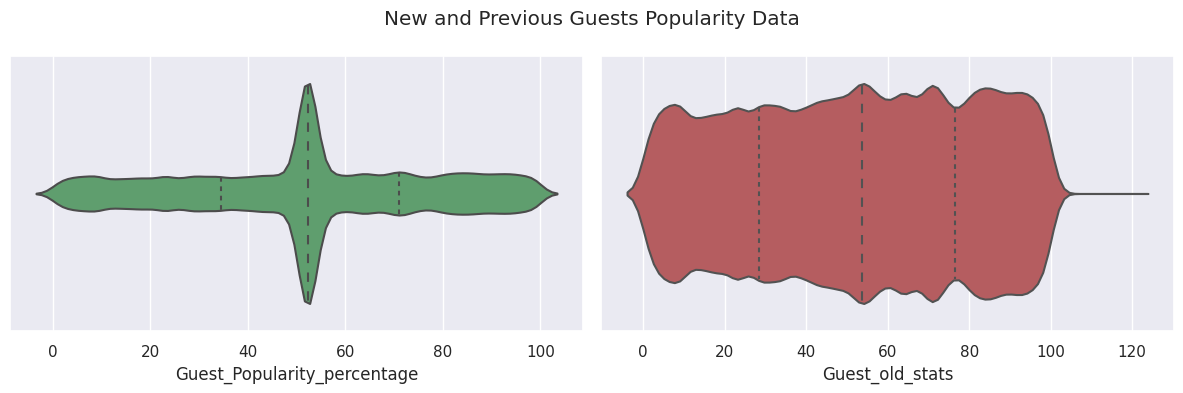

In [45]:
# We analyze the Guests popularity data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.violinplot(
    data=df_host_guest_stats, 
    x="Guest_Popularity_percentage",
    inner="quart",
    color="g",
    ax=axes[0]
)

sns.violinplot(
    data=df_host_guest_stats, 
    x="Guest_old_stats",
    inner="quart",
    color="r",
    ax=axes[1]
)

plt.suptitle(t="New and Previous Guests Popularity Data")
plt.tight_layout()
plt.show()

Note: We found a large difference in the distribution of values after completing them with the column average. We will see and analyze how this impacts later, and as an alternative, we will use a model to complete those values.

In [46]:
df_host_guest["Host_round"] = df_host_guest["Host_Popularity_percentage"].round(decimals=0).astype('Int64')
df_host_guest["Guest_round"] = df_host_guest["Guest_Popularity_percentage"].round(decimals=0).astype('Int64')
df_host_guest["Listening_time"] = listening_new["Listening_Time_minutes"].round(decimals=0).astype('Int64')

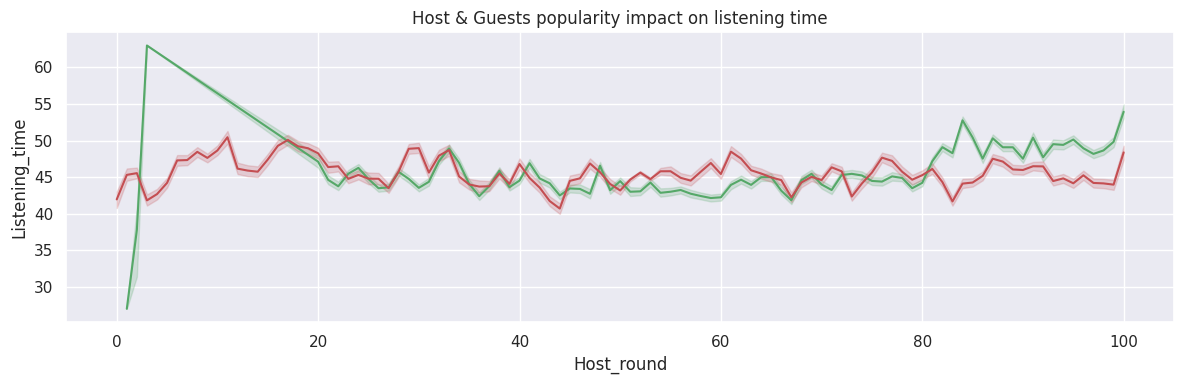

In [47]:
# We analyze the Host & Guests popularity

fig, axes = plt.subplots(figsize=(12, 4))

sns.lineplot(
    data=df_host_guest, 
    x="Host_round",
    y="Listening_time",
    color="g"
)

sns.lineplot(
    data=df_host_guest, 
    x="Guest_round",
    y="Listening_time",
    color="r"
)

plt.title(label="Host & Guests popularity impact on listening time")
plt.tight_layout()
plt.show()

The popularity of hosts and guests hovers around 50/60 percent. We can see that in the case of host popularity, we find some outliers: low popularity with high listening time. However, we can see that, while it's logical that the popularity of a host, or especially a guest, can influence the listening time of the respective episode, and therefore of the podcast as well, the values for both are centered along the same line.

- How much does the average amount of advertising on a podcast affect listening time?
- What day and time range records the longest podcast listening time?

In [48]:
ads_ltm = listening_new.pivot(
    columns="Number_of_Ads", values="Listening_Time_minutes"
)

ads_ltm.describe()

Number_of_Ads,0.0,1.0,2.0,3.0
count,217597.000000,214074.000000,158156.000000,160173.000000
mean,49.073661,47.274093,43.214216,40.237940
std,27.973183,28.527692,25.959952,24.042047
min,0.000000,0.000000,0.000000,0.000000
25%,26.484010,23.323490,22.228337,20.476830
50%,47.718430,45.241790,41.325260,38.410930
75%,69.941240,68.684440,61.480620,57.146750
max,119.970000,119.970000,119.970000,119.970000


In [49]:
popularity_ads = ads_ltm.sum().sort_values(ascending=False)

print(popularity_ads)

Number_of_Ads
0.0    1.067828e+07
1.0    1.012015e+07
2.0    6.834588e+06
3.0    6.445032e+06
dtype: float64


From the outset, we can see, as is logical, that the amount of advertising affects podcast listening time, ranging from an average of almost 50% for podcasts without ads, to 40% for those with the most ads.

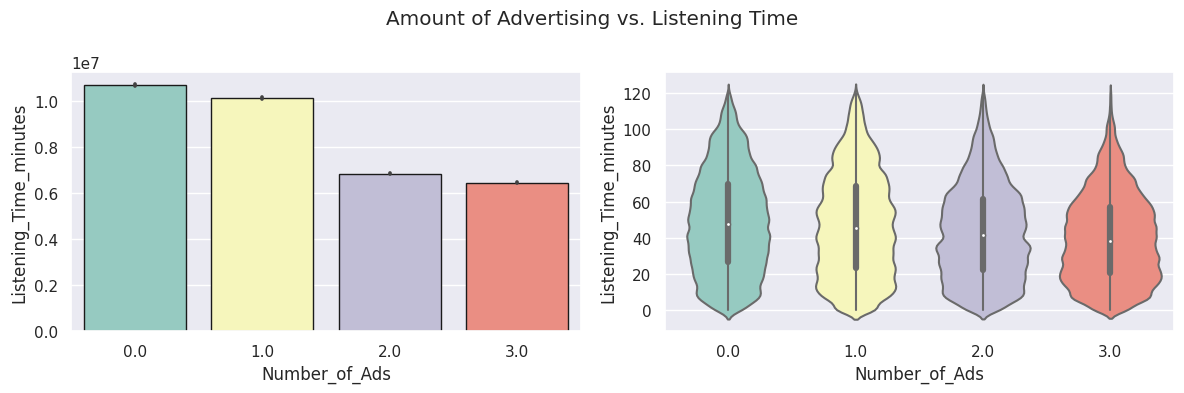

In [50]:
# We analyze the impact of the number of ads

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.barplot(
    data=listening_new, 
    x="Number_of_Ads",
    y="Listening_Time_minutes",
    estimator="sum",
    palette="Set3",
    edgecolor="k",
    ax=axes[0]
)

sns.violinplot(
    data=listening_new, 
    x="Number_of_Ads",
    y="Listening_Time_minutes",
    #estimator="sum",
    palette="Set3",
    edgecolor="k",
    ax=axes[1]
)

plt.suptitle(t="Amount of Advertising vs. Listening Time")
plt.tight_layout()
plt.show()

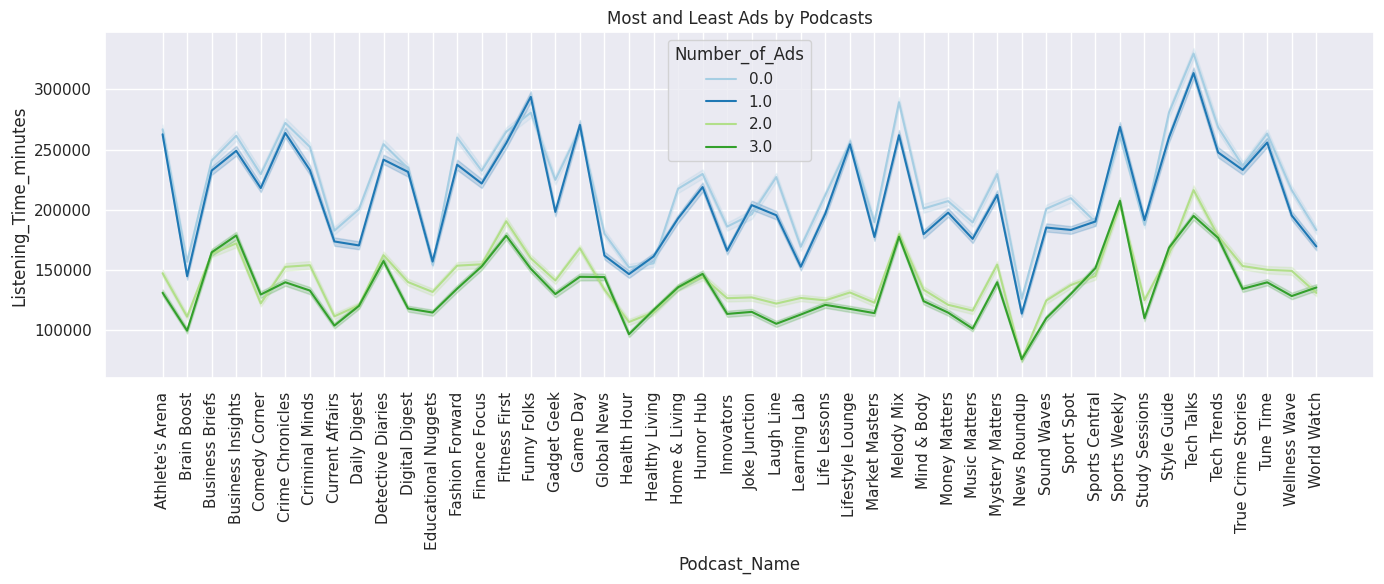

In [51]:
# We analyze the podcast advertising

fig, axes = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=listening_new, 
    x="Podcast_Name",
    y="Listening_Time_minutes",
    estimator="sum",
    hue="Number_of_Ads",
    palette="Paired",
).tick_params(axis='x', labelrotation=90)

plt.title(label="Most and Least Ads by Podcasts")
plt.tight_layout()
plt.show()

We can clearly see how the presence of advertising affects the playback time of episodes and the listening time of a podcast in general.

In [52]:
day_ltm = listening_new.pivot(
    columns="Publication_Day", values="Listening_Time_minutes"
)

day_ltm.describe()

Publication_Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,108237.000000,111963.000000,103505.000000,115946.000000,104360.000000,98103.000000,107886.000000
mean,45.206591,45.969630,45.326775,44.817398,44.869706,46.131411,45.807177
std,27.202850,26.631182,27.355689,26.790059,27.823074,27.150113,27.045870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.151200,24.018070,23.043660,23.274900,21.623540,23.810840,23.046250
50%,42.894310,44.229340,42.257780,42.841590,42.231935,44.410630,44.505370
75%,64.763040,65.351220,64.603750,62.714440,64.821700,66.153865,65.313750
max,119.970000,119.970000,119.970000,119.970000,119.970000,119.970000,119.970000


In [53]:
time_ltm = listening_new.pivot(
    columns="Publication_Time", values="Listening_Time_minutes"
)

time_ltm.describe()

Publication_Time,Afternoon,Evening,Morning,Night
count,179460.000000,195778.000000,177913.000000,196849.000000
mean,45.525603,44.761567,44.964415,46.456655
std,27.341756,26.957539,27.290110,26.962001
min,0.000000,0.000000,0.000000,0.000000
25%,23.054770,22.942560,22.454080,24.364550
50%,43.554655,42.453110,42.503700,44.831020
75%,64.630000,63.646340,65.046680,65.859500
max,119.970000,119.970000,119.970000,119.970000


In a first analysis, we can observe that the day and time of publication does not have much influence, considering that the average listening time is handled within the same ranges, we do not find major differences in the values.

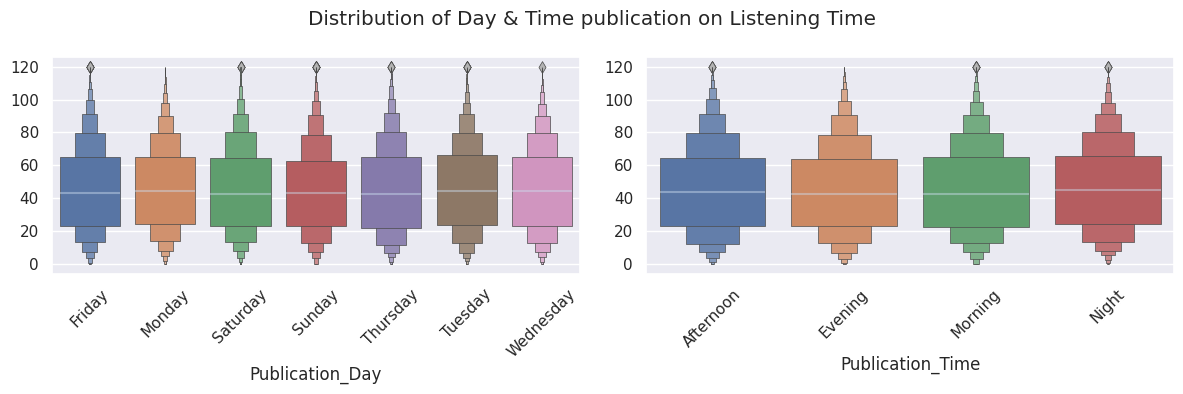

In [54]:
# We analyze the impact of day and time

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.boxenplot(
    data=day_ltm,
    linewidth=.5,
    line_kws=dict(linewidth=1.5, color="#cde"),
    flier_kws=dict(facecolor=".7", linewidth=.5),
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)

sns.boxenplot(
    data=time_ltm,
    linewidth=.5,
    line_kws=dict(linewidth=1.5, color="#cde"),
    flier_kws=dict(facecolor=".7", linewidth=.5),
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Distribution of Day & Time publication on Listening Time")
plt.tight_layout()
plt.show()

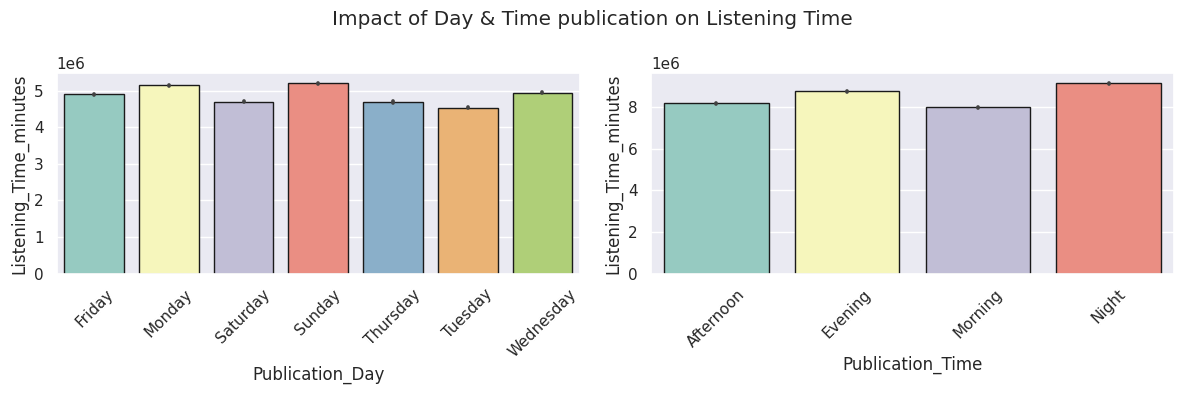

In [55]:
# We analyze the impact of the number of ads

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.barplot(
    data=listening_new, 
    x="Publication_Day",
    y="Listening_Time_minutes",
    estimator="sum",
    palette="Set3",
    edgecolor="k",
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)

sns.barplot(
    data=listening_new, 
    x="Publication_Time",
    y="Listening_Time_minutes",
    estimator="sum",
    palette="Set3",
    edgecolor="k",
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Impact of Day & Time publication on Listening Time")
plt.tight_layout()
plt.show()

We see that the distribution of values doesn't differ markedly by day or time of publication. We can observe that Sundays and Mondays register the highest amount of listening time, and that at night is when most podcasts are published and listened to. We could deduce that on Sunday evening, most podcasts are published and listened to, until early Monday morning.

# Data preprocessing

Next we will finish preprocessing the data. We have already completed the initial part, now we will complete the process by feature selection, encoding, and scaling the data where necessary.

In [56]:
listening_end = listening_new.copy()

In [57]:
listening_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 750000 non-null  category
 1   Episode_Title                750000 non-null  category
 2   Episode_Length_minutes       750000 non-null  float64 
 3   Genre                        750000 non-null  category
 4   Host_Popularity_percentage   750000 non-null  float64 
 5   Publication_Day              750000 non-null  category
 6   Publication_Time             750000 non-null  category
 7   Guest_Popularity_percentage  750000 non-null  float64 
 8   Number_of_Ads                750000 non-null  float64 
 9   Episode_Sentiment            750000 non-null  category
 10  Listening_Time_minutes       750000 non-null  float64 
dtypes: category(6), float64(5)
memory usage: 38.6 MB


In [58]:
listening_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [59]:
listening_train.describe(exclude = np.number).T

,count,unique,top,freq
Podcast_Name,750000,48,Tech Talks,22847
Episode_Title,750000,100,Episode 71,10515
Genre,750000,10,Sports,87606
Publication_Day,750000,7,Sunday,115946
Publication_Time,750000,4,Night,196849
Episode_Sentiment,750000,3,Neutral,251291


## Encoding

We'll map the ordinal variables, and use OrdinalEncoder for the rest, with categories='auto' for the nominal data. We could use OneHotEncoder for the Genre variable, but we'll try to maintain the dataset's dimensionality for now, and we don't have a binary categorical variable to use with it.

In [60]:
# We map the variables and change the format

eps_order = {"Negative" : 0, "Neutral" : 1, "Positive" : 2}
listening_end["Episode_Sentiment"] = listening_end["Episode_Sentiment"].map(eps_order)
listening_end["Episode_Sentiment"] = listening_end["Episode_Sentiment"].astype("float64")

In [61]:
# We separate the categorical variables from the numerical ones

df_numerical = listening_end.select_dtypes(include="number")
df_categorical = listening_end.select_dtypes(include="category")

In [62]:
# We apply OrdinalEncoder to the remaining categorical variables

enc = OrdinalEncoder(categories="auto")

enc_data = enc.fit_transform(df_categorical)

# Creating a DataFrame with the encoded data and then join them

df_encoded = pd.DataFrame(enc_data, columns=enc.get_feature_names_out(df_categorical.columns))

df_listening = pd.concat([df_encoded, df_numerical], axis=1)

In [63]:
df_listening.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  float64
 1   Episode_Title                750000 non-null  float64
 2   Genre                        750000 non-null  float64
 3   Publication_Day              750000 non-null  float64
 4   Publication_Time             750000 non-null  float64
 5   Episode_Length_minutes       750000 non-null  float64
 6   Host_Popularity_percentage   750000 non-null  float64
 7   Guest_Popularity_percentage  750000 non-null  float64
 8   Number_of_Ads                750000 non-null  float64
 9   Episode_Sentiment            750000 non-null  float64
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(11)
memory usage: 62.9 MB


In [64]:
df_listening.describe().style.background_gradient(cmap='Greens')

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,23.515731,50.286004,4.648788,2.962776,1.522868,64.502390,59.859482,52.233200,1.347873,0.997969,45.437406
std,14.137577,28.186681,2.963073,1.997399,1.119361,31.001442,22.872221,25.533619,1.110966,0.815440,27.138306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,26.000000,2.000000,1.000000,1.000000,39.420000,39.410000,34.550000,0.000000,0.000000,23.178350
50%,23.000000,51.000000,5.000000,3.000000,1.000000,64.423470,60.050000,52.430000,1.000000,1.000000,43.379460
75%,37.000000,74.000000,7.000000,5.000000,3.000000,90.310000,79.530000,71.040000,2.000000,2.000000,64.811580
max,47.000000,99.000000,9.000000,6.000000,3.000000,325.240000,100.000000,100.000000,3.000000,2.000000,119.970000


Next we will make an initial correlation evaluation.

In [65]:
df_listening.corr().style.background_gradient(cmap='Greens')

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
Podcast_Name,1.000000,0.006669,0.188052,0.003117,-0.002328,0.006335,-0.002424,-0.004750,0.008955,0.003115,0.004346
Episode_Title,0.006669,1.000000,0.006847,0.001100,-0.000304,-0.019925,0.020208,0.034565,0.006395,-0.004845,-0.020842
Genre,0.188052,0.006847,1.000000,0.003305,-0.001329,-0.000452,-0.008807,0.007005,-0.003429,-0.001588,0.004940
Publication_Day,0.003117,0.001100,0.003305,1.000000,-0.000860,0.006598,-0.003698,0.000398,0.004986,0.004594,0.004030
Publication_Time,-0.002328,-0.000304,-0.001329,-0.000860,1.000000,0.009908,0.000182,-0.005023,-0.006727,0.008923,0.013225
Episode_Length_minutes,0.006335,-0.019925,-0.000452,0.006598,0.009908,1.000000,0.022221,-0.008353,-0.054821,0.024724,0.866202
Host_Popularity_percentage,-0.002424,0.020208,-0.008807,-0.003698,0.000182,0.022221,1.000000,0.020061,-0.017831,0.007063,0.050854
Guest_Popularity_percentage,-0.004750,0.034565,0.007005,0.000398,-0.005023,-0.008353,0.020061,1.000000,0.007659,0.000488,-0.014399
Number_of_Ads,0.008955,0.006395,-0.003429,0.004986,-0.006727,-0.054821,-0.017831,0.007659,1.000000,-0.020627,-0.124201
Episode_Sentiment,0.003115,-0.004845,-0.001588,0.004594,0.008923,0.024724,0.007063,0.000488,-0.020627,1.000000,0.039470


<Axes: >

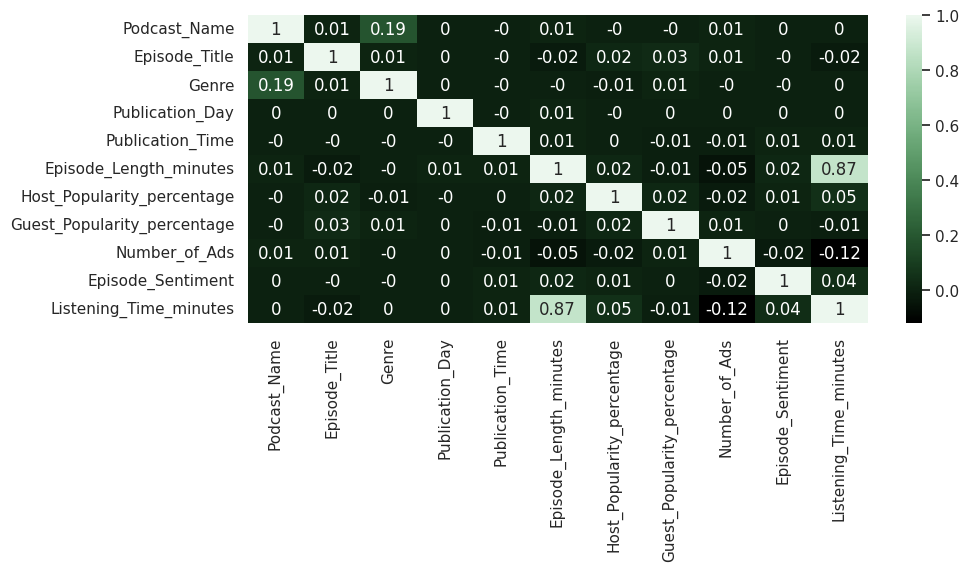

In [66]:
# We graph the correlation between the variables

matrix_listening = df_listening.corr(numeric_only=True).round(2)

plt.figure(figsize=(10, 4))

sns.heatmap(
    matrix_listening, 
    annot=True,
    cmap=sns.cubehelix_palette(
        start=2, rot=0, 
        dark=0, light=.95, 
        reverse=True, as_cmap=True
    )
)

We clearly see different scales in the variables we should manage. On the other hand, we could omit some variables, taking into account their correlation. We will keep the dataset dimension for now.

## Scaling

We will proceed to scale using the most appropriate method for our data. We found different scales by analyzing the description of our data previously.

In [67]:
df_listening.describe().T

,count,mean,std,min,25%,50%,75%,max
Podcast_Name,750000.0,23.515731,14.137577,0.0,11.00000,23.00000,37.00000,47.00
Episode_Title,750000.0,50.286004,28.186681,0.0,26.00000,51.00000,74.00000,99.00
Genre,750000.0,4.648788,2.963073,0.0,2.00000,5.00000,7.00000,9.00
Publication_Day,750000.0,2.962776,1.997399,0.0,1.00000,3.00000,5.00000,6.00
Publication_Time,750000.0,1.522868,1.119361,0.0,1.00000,1.00000,3.00000,3.00
Episode_Length_minutes,750000.0,64.502390,31.001442,0.0,39.42000,64.42347,90.31000,325.24
Host_Popularity_percentage,750000.0,59.859482,22.872221,1.3,39.41000,60.05000,79.53000,100.00
Guest_Popularity_percentage,750000.0,52.233200,25.533619,0.0,34.55000,52.43000,71.04000,100.00
Number_of_Ads,750000.0,1.347873,1.110966,0.0,0.00000,1.00000,2.00000,3.00
Episode_Sentiment,750000.0,0.997969,0.815440,0.0,0.00000,1.00000,2.00000,2.00


We will scale only the initial numeric variables. We will retain the ranges of the categorical variables we mapped and encoded.

In [68]:
# We separate the target variable from the features and data to scale

x_listening = df_listening.drop(columns="Listening_Time_minutes")
y_listening = df_listening["Listening_Time_minutes"]

In [69]:
# Numerical variables to scale

df_numeric = x_listening[[
    "Episode_Length_minutes",
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage"
]]

# We transform the data

scaler = StandardScaler()

scale_num = scaler.fit_transform(df_numeric)

df_scale = pd.DataFrame(
    scale_num, columns=scaler.get_feature_names_out(df_numeric.columns)
)

In [70]:
# We create a df with the remaining variables

df_rest = x_listening.drop(
    columns=["Episode_Length_minutes",
             "Host_Popularity_percentage",
             "Guest_Popularity_percentage"]
)

# We concatenate the dataframes

x_end = pd.concat([df_rest, df_scale], axis=1)

In [71]:
x_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Podcast_Name,750000.0,2.351573e+01,14.137577,0.000000,11.000000,23.000000,37.000000,47.000000
Episode_Title,750000.0,5.028600e+01,28.186681,0.000000,26.000000,51.000000,74.000000,99.000000
Genre,750000.0,4.648788e+00,2.963073,0.000000,2.000000,5.000000,7.000000,9.000000
Publication_Day,750000.0,2.962776e+00,1.997399,0.000000,1.000000,3.000000,5.000000,6.000000
Publication_Time,750000.0,1.522868e+00,1.119361,0.000000,1.000000,1.000000,3.000000,3.000000
Number_of_Ads,750000.0,1.347873e+00,1.110966,0.000000,0.000000,1.000000,2.000000,3.000000
Episode_Sentiment,750000.0,9.979693e-01,0.815440,0.000000,0.000000,1.000000,2.000000,2.000000
Episode_Length_minutes,750000.0,2.563828e-16,1.000001,-2.080627,-0.809072,-0.002546,0.832465,8.410505
Host_Popularity_percentage,750000.0,-2.175208e-16,1.000001,-2.560290,-0.894076,0.008330,0.860018,1.754991
Guest_Popularity_percentage,750000.0,-5.623709e-17,1.000001,-2.045665,-0.692546,0.007707,0.736551,1.870743


## Feature Selection

We will continue evaluating the features based on their mutual importance, having already performed a correlative analysis, and then make a selection based on a complete analysis of their relationship and importance.

In [72]:
mi_scores = mutual_info_regression(x_end, y_listening)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_end.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Episode_Length_minutes         2.014038
Host_Popularity_percentage     0.762984
Episode_Title                  0.684553
Guest_Popularity_percentage    0.644383
Podcast_Name                   0.417435
Publication_Day                0.244090
Number_of_Ads                  0.239591
Genre                          0.200268
Publication_Time               0.176122
Episode_Sentiment              0.140863
Name: MI Scores, dtype: float64

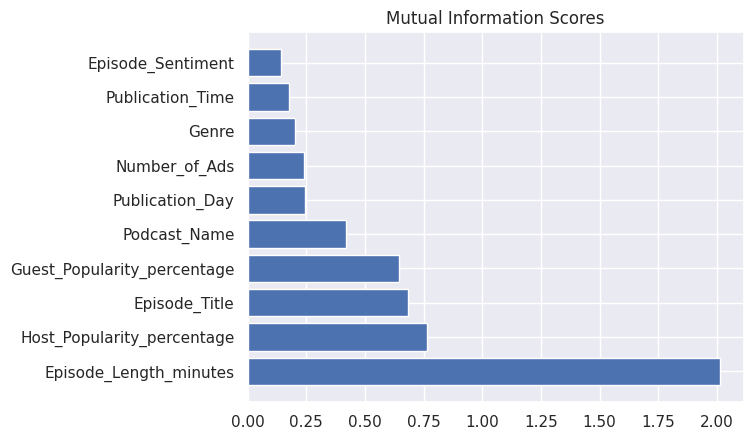

<Figure size 800x500 with 0 Axes>

In [73]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()

Based on correlation and mutual importance, we could reduce dimensionality by removing certain variables, but we will retain all the features for an initial evaluation of the models performance with all the data.